# __Predicting the Survival of Titanic Passengers__

### __Titanic - Machine Learning from Disaster__
#### Start here! Predict survival on the Titanic and get familiar with ML basics

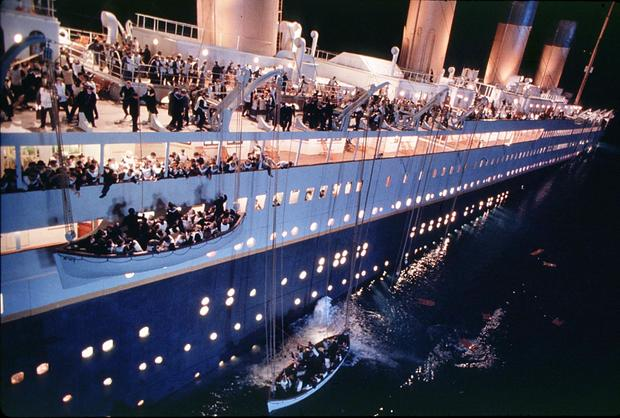

## __RMS Titanic__

> _The RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of __15 April 1912__, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated __2,224__ passengers and crew aboard the ship, and more than __1,500__ died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster._

### __Data Description__

---

##### __Overview__

The data has been split into two groups:

* training set (train.csv)
* test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, as an example of what a submission file should look like.

##### __Data Dictionary__
| Variable |	Definition	                               | Key                       |
|----------|:----------------------------------------------|:--------------------------|
|survival  |	Survival                                   |	0 = No, 1 = Yes        |
|pclass    |	Ticket class                               |	1 = 1st, 2 = 2nd, 3 = 3rd |
|sex       |	Sex                                        |	                       |
|Age       |	Age in years                               |	                       |
|sibsp     |	# of siblings / spouses aboard the Titanic |	|
|parch     |	# of parents / children aboard the Titanic |	|
|ticket    |	Ticket number                              |	                       |
|fare      |	Passenger fare                             |	                       |
|cabin     |	Cabin number                               |	                       |
|embarked  |	Port of Embarkation                        |	C = Cherbourg, Q = Queenstown, S = Southampton|

##### __Variable Notes__

__pclass__: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower


__age__ : Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5


__sibsp__ : The dataset defines family relations in this way

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)


__parch__ : The dataset defines family relations in this way

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them

### __Table of content__

---

* __Part 1 - Data Preprocessing__
    1. Importing Libraries
    2. Importing Datasets
    3. Exploration Data Analysis (EDA)
        * Dataset Information (Pandas Profiling)
        * Data Preprocessing
            * Missing data
            * Converting Features
        * Creating Categories
        * Creating New Features
        
* __Part 2 - Building and Training the Classification model__
    1. Random Forest
    2. Logestic Regresion
    3. K Nearest Neighbor
    4. Accuracy Score
    
* __Part 3 - Creating a submission.csv__

---

# __Part 1 - Data Preprocessing__

Installation __'pandas-profiling'__ for generates profile reports from a pandas DataFrame

In [ ]:
!pip install pandas-profiling

## __1. Importing Libraries__

In [ ]:
# Linear Algebra
import numpy as np 
# Data Processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# Pandas Profiling
import pandas_profiling as pp

# Data Visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')


## __2. Import Datasets__

In [ ]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

## **3. Exploration Data Analysis**

In [ ]:
train_df.info()

__The training-set has 891 examples and 11 features + the target variable (survived).__  2 of the features are floats, 5 are integers and 5 are objects.

In [ ]:
train_df.describe()

Above we can see that __38% out of the training-set servived the titanic.__
We can also see that the passenger ages range from __0.4 to 80__.

 * ### **Dataset information (Pandas Profiling)**

In [ ]:
pp.ProfileReport(train_df, title= 'Pandas Profile report of "Train" set', html= {'style':{'full_width': True}})

Above we can see that 5 of the features are numeric and 7 of categorical. From the table above, we can note a few things.
First of all, that we **need to convert a lot of features into numeric** ones later on, so that the machine learning algorithms
can process them. Furthermore, we can see that the **features have widly different ranges**, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values(NaN = Not a Number), that wee need to deal with.

__Let’s take a more detailed look at what data is actually missing:__

In [ ]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

According tables of __"Missing Values"__ in pandas profile and above table, the __Embarked__ feature has only __2 missing values__, which can easily be filled. It will be much more tricky, to deal with the __‘Age’__ feature, which has __177 missing values__. The __‘Cabin’__ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since __77 % of it are missing__.

To me it would make sense if everything except __‘PassengerId’__, __‘Ticket’__ and __‘Name’__ would be correlated with a high survival rate.

#### __1. Age and Sex__

In [ ]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']
ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(), bins= 18, label= survived, ax= axes[0], kde= False)
ax.legend()
ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(), bins= 40, label= not_survived, ax= axes[0], kde= False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(), bins= 18, label= survived, ax= axes[1], kde= False)
ax.legend()
ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(), bins= 40, label= not_survived, ax= axes[1], kde= False)
ax.legend()
ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 40 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

Since there seem to be __certain ages, which have increased odds of survival__ and because I want every feature to be roughly on the same scale, I will create age groups later on.

#### __2. Embarked, Pclass and Sex__

In [ ]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender.

Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

Pclass also seems to be correlated with survival. We will generate another plot of it below.

#### __3. Pclass__

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

In [ ]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

#### __4. SibSp and Parch__

SibSp and Parch would make __more sense as a combined feature__, that shows the __total number of relatives, a person has on the Titanic__. I will create it below and also a feature that sows if someone is not alone.

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
    # print(dataset)
    
train_df['not_alone'].value_counts()


In [ ]:
axes = sns.factorplot('relatives','Survived', data=train_df, aspect = 2.5, )

Here we can see that you had a __high probabilty of survival with 1 to 3 realitves__, but a __lower one if you had less than 1 or more than 3__ (except for some cases with 6 relatives).

* ### __Data Preprocessing__

First, I will __drop ‘PassengerId’__ from the train set, because it does not contribute to a persons survival probability. I __will not drop it from the test set__, since it is required there for the submission.

In [ ]:
train_df = train_df.drop(['PassengerId'], axis=1)

  * #### __Missing Data__

__Cabin:__

As a reminder, we have to deal with Cabin (687), Embarked (2) and Age (177). First I thought, we have to delete the ‘Cabin’ variable but then I found something interesting. A cabin number looks like ‘C123’ and the __letter refers to the deck__. Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero. In the picture below you can see the actual decks of the titanic, ranging from A to G.

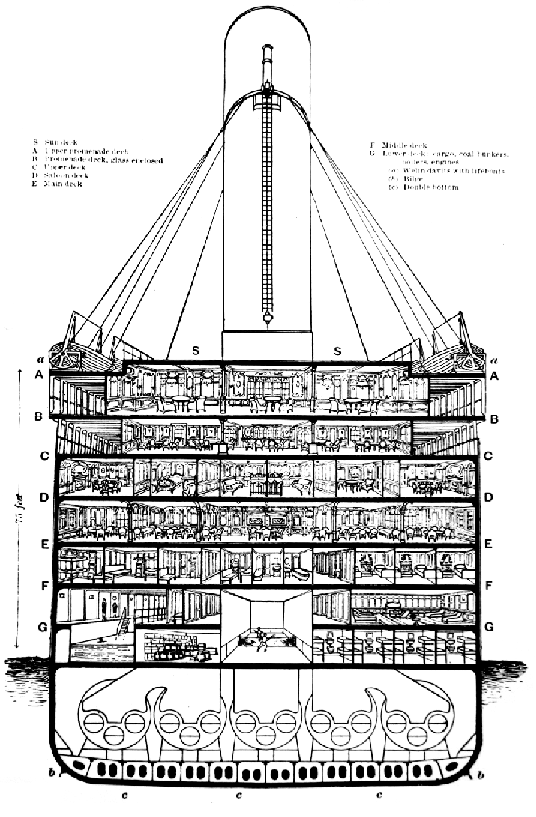

In [ ]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
# We can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [ ]:
train_df

__Age:__

Now we can tackle the issue with the age features missing values. I will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.

In [ ]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df['Age'].mean()
    std = test_df['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    # Compute random number between mean , std and is_null
    rand_age = np.random.randint(mean - std, mean + std, is_null)
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice
    dataset['Age'] = train_df['Age'].astype(int)
    
train_df['Age'].isnull().sum()

__Embarked:__

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [ ]:
train_df['Embarked'].describe()

In [ ]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)
    
train_df['Embarked'].isnull().sum()

* #### __Converting Features:__

In [ ]:
train_df.info()

Above you can see that _‘Fare’_ is a float and we have to deal with 4 categorical features: _Name, Sex, Ticket and Embarked_. Lets investigate and transfrom one after another.

__Fare:__

Converting “Fare” from float to int64, using the “astype()” function pandas provides:

In [ ]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

__Name:__

We will use the Name feature to extract the Titles from the Name, so that we can build a new feature out of that.

In [ ]:
data = [train_df, test_df]
titles = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}

for dataset in data:
    # Extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([a-zA-Z]+)\.', expand= False)
    # Replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Cap', 'Col', 'Don', 'Dr'\
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    # Convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # Filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].astype(int)
    
train_df = train_df.drop(['Name'], axis= 1)
test_df = test_df.drop(['Name'], axis= 1)

__Sex:__

Convert ‘Sex’ feature into numeric.

In [ ]:
genders = {'male': 0, 'female': 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

__Ticket:__

In [ ]:
train_df['Ticket'].describe()

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [ ]:
train_df = train_df.drop(['Ticket'], axis= 1)
test_df = test_df.drop(['Ticket'], axis= 1)

__Embarked:__

Convert ‘Embarked’ feature into numeric.

In [ ]:
ports = {'S': 0, 'C': 1, 'Q': 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

+ ### __Creating Categories:__

We will now create categories within the following features:

__Age:__

**Now we need to convert the ‘age’ feature. First we will convert it from float into integer. Then we will create the new ‘AgeGroup” variable, by categorizing every age into a group. Note that it is important to place attention on how you form these groups, since you don’t want for example that 80% of your data falls into group 1.**

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[dataset['Age'] > 66, 'Age'] = 6
    
# let's see how it's distributed 
train_df['Age'].value_counts()

__Fare:__

For the ‘Fare’ feature, we need to do the same as with the ‘Age’ feature. But it isn’t that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn “qcut()” function, that we can use to see, how we can form the categories.

In [ ]:
train_df.head()

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
# let's see how it's distributed
train_df['Fare'].value_counts()

* ### __Creating new Features__

I will add two new features to the dataset, that I compute out of other features.

#### __1. Age times Class__

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

#### __2. Fare per Person__

In [ ]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['relatives'] + 1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    
# Let's take a last look at the training set, before we start training the models.
train_df.head(10)

# __Part 2 - Building and Training the Classification model__

Now we will train several Machine Learning models and compare their results. Note that because the dataset does not provide labels for their testing-set, we need to use the predictions on the training set to compare the algorithms with each other. Later on, we will use cross validation.

In [ ]:
X_train = train_df.drop(['Survived'], axis= 1)
Y_train = train_df['Survived']
X_Test = test_df.drop(['PassengerId'], axis= 1).copy()

### 1. __Random Forest:__

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_Test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

 ### 2. __Logistic Regression:__

In [ ]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_Test)

acc_logreg = round(logreg.score(X_train, Y_train) * 100, 2)

### 3. __K Nearest Neighbor:__

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_Test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

## __Which is the best Model ?__

In [ ]:
results = pd.DataFrame({'Model': ['KNN', 'Logestic Regresion', 'Random Forest'],\
                       'Score': [acc_knn, acc_logreg, acc_random_forest]})
result_df = results.sort_values(by= 'Score', ascending= False)
result_df = result_df.set_index('Score')
result_df.head()

As we can see, the __Random Forest classifier goes on the first place__. But first, let us check, how random-forest performs, when we use __cross validation__.

## __K-Fold Cross Validation:__

K-Fold Cross Validation randomly splits the training data into __K subsets called folds__.
The code below perform K-Fold Cross Validation on our random forest model, using 10 folds (K = 10). Therefore it outputs an array with 10 different scores.

In [ ]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators= 100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring= "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

This looks much more realistic than before. Our model has a __average accuracy of 82% with a standard deviation of 4 %__. The standard deviation shows us, how precise the estimates are .

This means in our case that the accuracy of __our model can differ + - 4%__.

I think the accuracy is still really good and since random forest is an easy to use model, we will try to increase it’s performance even further in the following section.

### __Random Forest__

To say it in simple words: __Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction__.

__One big advantage of random forest is, that it can be used for both classification and regression problems__, which form the majority of current machine learning systems. With a few exceptions a random-forest classifier has all the hyperparameters of a decision-tree classifier and also all the hyperparameters of a bagging classifier, to control the ensemble itself.

__The random-forest algorithm brings extra randomness into the model, when it is growing the trees__. Instead of __searching for the best feature while splitting a node, it searches for the best feature among a random subset of features__. This process creates a __wide diversity__, which __generally results in a better model__. Therefore when you are growing a tree in random forest, only a random subset of the features is considered for splitting a node. You can even make trees more random, by using random thresholds on top of it, for each feature rather than searching for the best possible thresholds (like a normal decision tree does).

### __Feature Importance__

__Another great quality of random forest is that they make it very easy to measure the relative importance of each feature__. Sklearn measure a features importance by looking at how much the treee nodes, that use that feature, __reduce impurity on average (across all trees in the forest)__. It computes this score automaticall for each feature after training and scales the results so that the __sum of all importances is equal to 1__. We will acces this below:

In [ ]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(random_forest.feature_importances_, 3)})
importances = importances.sort_values('importance', ascending= False).set_index('feature')

importances.head(15)

In [ ]:
importances.plot.bar()

### __Conclusion:__


__not_alone__ and __Parch__ __doesn’t play a significant role in our random forest classifiers prediction process__. Because of that __I will drop them__ from the dataset and train the classifier again. We could also remove more or less features, but this would need a more detailed investigation of the features effect on our model. But I think it’s just fine to remove only Alone and Parch.

In [ ]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

__Training random forest again:__

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, oob_score= True)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_Test)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

print(round(acc_random_forest, 2), '%')

Our random forest model predicts as good as it did before. A general rule is that, the __more features you have, the more likely your model will suffer from overfitting__ and vice versa. But I think our data __looks fine for now__ and hasn't too much features.

__There is also another way to evaluate a random-forest classifier, which is probably much more accurate than the score we used before__. What I am talking about is the __out-of-bag samples__ to estimate the generalization accuracy. I will not go into details here about how it works.

In [ ]:
print("oob score:", round(random_forest.oob_score_, 4) * 100, '%')

Now we can start tuning the hyperameters of random forest.

### __Hyperparameter Tuning__

Below you can see the code of the __hyperparamter tuning__ for the parameters __criterion, min_samples_leaf, min_samples_split__ and __n_estimators__.

I put this code into a comment, because it takes a long time to run it. Directly underneeth it, I put a screenshot of the gridsearch's output.

In [ ]:
# param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
#from sklearn.model_selection import GridSearchCV, cross_val_score 

# rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

# clf = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)

# clf.fit(X_train, Y_train)

# clf.best_params_

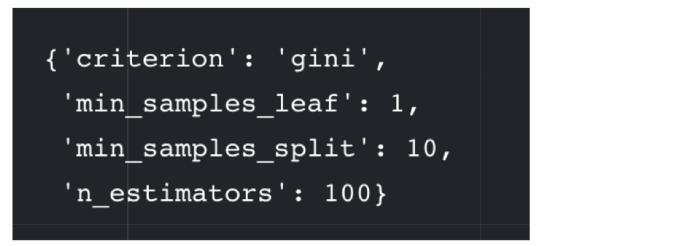

__another run__

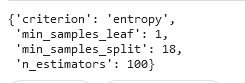

__Test new Parameters:__

In [ ]:
random_forest = RandomForestClassifier(criterion= 'gini', min_samples_leaf= 1, min_samples_split= 10,
                                       n_estimators= 100, max_features= 'auto', oob_score= True,
                                       random_state= 1, n_jobs= -1)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_Test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

Now that we have a proper model, we can start evaluating it’s performace in a more accurate way. Previously we only used accuracy and the oob score, which is just another form of accuracy. The problem is just, that it’s more complicated to evaluate a classification model than a regression model. We will talk about this in the following section.

## __Further Evaluation__

### __Confusion Matrix:__

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

predictions = cross_val_predict(random_forest, X_train, Y_train, cv= 3)
confusion_matrix(Y_train, predictions)

In [ ]:
plot_confusion_matrix(random_forest, X_train, Y_train)

### __Precision, Recall and F-Score:__

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))
print("F1-Score:", f1_score(Y_train, predictions))

Our model predicts __82%__ of the time, a passengers survival correctly (__precision__). The __recall__ tells us that it predicted the survival of __74 %__ of the people who actually survived.

You can __combine precision and recall into one score__, which is called the __F-score__. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

There we have it, a __77 % F-score__. __The score is not that high__, because we have a __recall of 74%__. But unfortunately the F-score is not perfect, because it favors classifiers that have a similar precision and recall. This is a problem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, sometimes results in an decreasing recall and vice versa (depending on the threshold). This is called the precision/recall tradeoff.

### __Precision Recall Curve__

We will plot the precision and recall with the threshold using matplotlib:

In [ ]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Above you can clearly see that the __recall is falling of rapidly at a precision__ of around __82%__. Because of that you may want to select the precision/recall tradeoff before that — maybe at around __75 %__.

You are now able to choose a threshold, that gives you the best precision/recall tradeoff for your current machine learning problem. If you want for example a precision of __80%__, you can easily look at the plots and see that you would need a threshold of around 0.4. Then you could train a model with exactly that threshold and would get the desired accuracy.

Another way is to plot the precision and recall against each other:

In [ ]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

### __ROC AUC Curve__

Another way to evaluate and compare your binary classifier is provided by the __ROC AUC Curve__. This curve plots the __true positive rate (also called recall)__ against the __false positive rate (ratio of incorrectly classified negative instances)__, instead of plotting the precision versus the recall.

In [ ]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

### __ROC AUC Score__

The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC.

A classifiers that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.

In [ ]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

Nice ! I think that score is good enough to submit the predictions for the test-set to the Kaggle leaderboard.

# __Part 3 - Creating a submission.csv__

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })

In [ ]:
submission.to_csv('submission.csv', index=False)

# __In conclusion__

__There are many things for a greater chance to survive. Being a female or a child will increase you chances. If you have a higher class ticket you have the more chance of surviving than a third class ticket. As for a man, you are more likely to survive if embark in Cherbourg compare to Southampton or Queenstown. If you also travel with 1 or 3 people than 0 or more than 3 your survival chances are greater. The younger you are will also make your survival chance. So it comes down to many things to surivive on the titanic.__

# __If you liked my work then please upvote, Thank you.__